In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'Balanced LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0
(218, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

In [6]:
r_test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0
(215, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labe

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


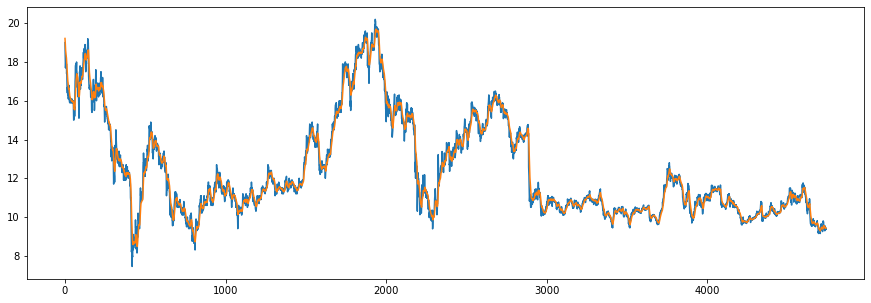

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


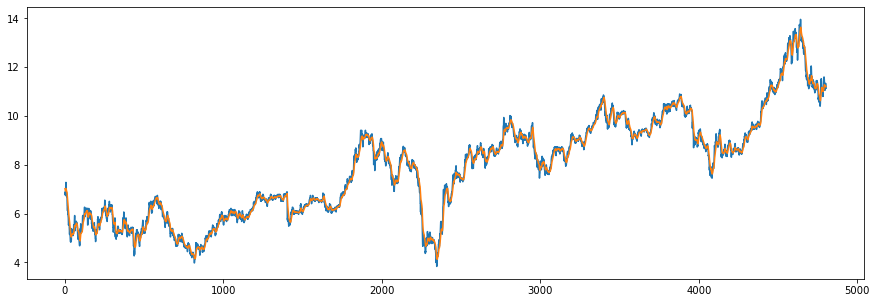

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     3.189194  3.249583 -69.696967   61394527.0     2.0
2000-01-25     3.205140  3.242745 -79.136806   75032521.0     2.0
2000-01-26     3.402870  3.267380 -34.532549  127274101.0     2.0
2000-01-27     3.284870  3.270071 -62.500055   91746305.0     2.0
2000-01-28     3.252978  3.267441 -69.852957   65314909.0     2.0


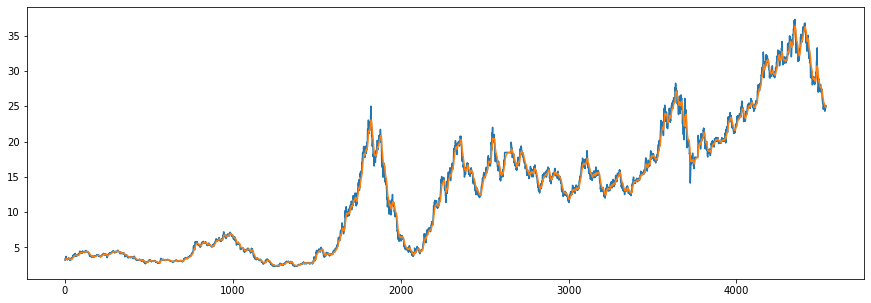

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


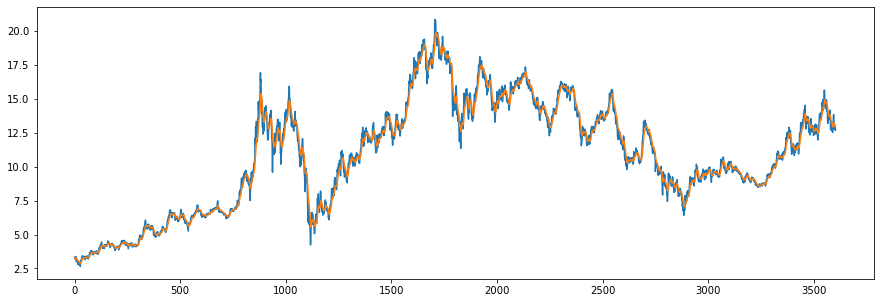

            previous_1d    EMA_12   willr_14         OBV_7  labels
Date                                                              
2006-11-17     3.953848  3.652647 -15.942120  1.897904e+10     2.0
2006-11-20     3.934226  3.695967 -18.840636  1.837444e+10     2.0
2006-11-21     3.934226  3.732622 -19.403036  1.837444e+10     2.0
2006-11-22     3.934226  3.763638 -19.697025  1.837444e+10     0.0
2006-11-23     4.051959  3.807995  -1.562480  1.907354e+10     2.0


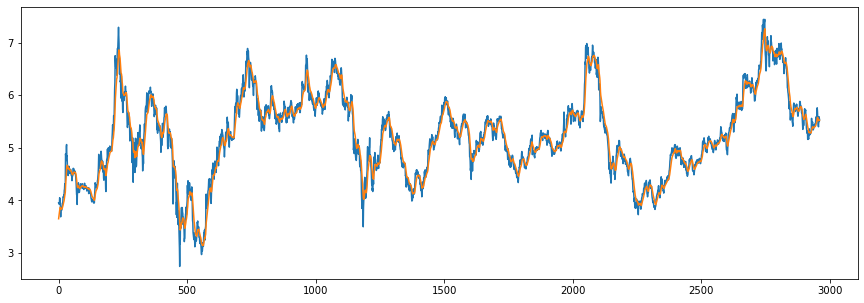

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      21.5000  24.211693 -82.142857  -6805500.0     2.0
2000-01-24      20.2500  23.602201 -92.465753  -8986800.0     1.0
2000-01-25      20.1875  23.076863 -92.307692 -11383100.0     2.0
2000-01-26      20.8750  22.738115 -82.786885  -9392500.0     2.0
2000-01-27      22.8750  22.759174 -56.557377  -6811000.0     2.0


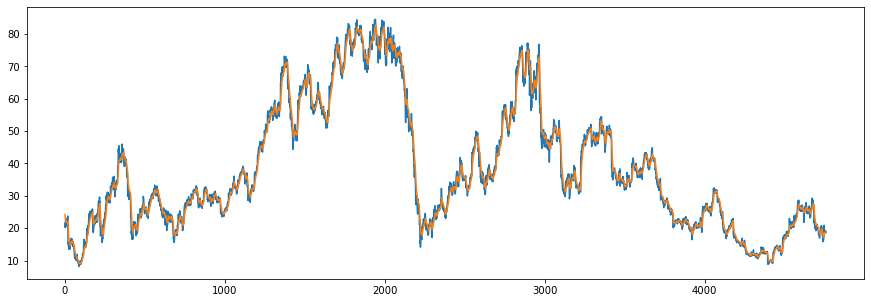

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


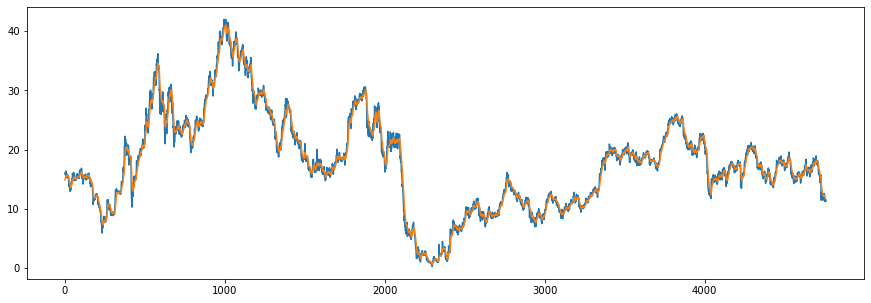

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


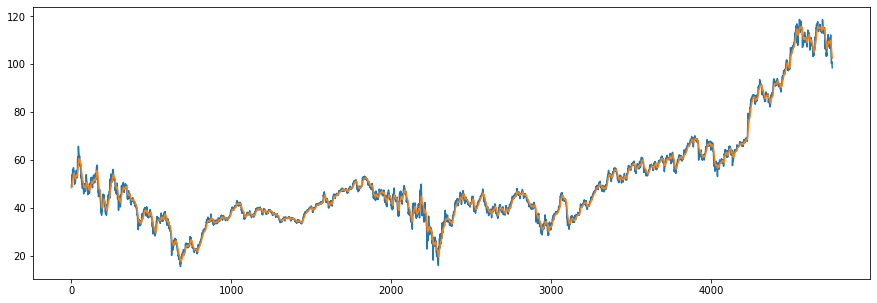

            previous_1d     EMA_12    willr_14     OBV_7  labels
Date                                                            
2000-01-21      13.7500  14.817184  -97.297297 -827200.0     2.0
2000-01-24      14.0625  14.701079  -77.500000 -518900.0     2.0
2000-01-25      13.6875  14.545144  -92.500000 -906100.0     2.0
2000-01-26      13.7500  14.422814  -90.000000 -652700.0     2.0
2000-01-27      13.5000  14.280843 -100.000000 -848400.0     2.0


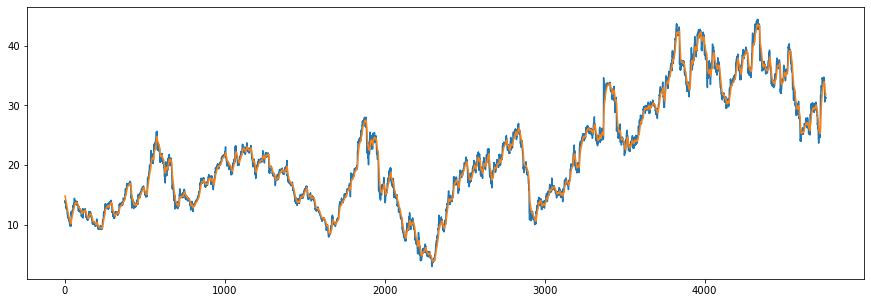

            previous_1d     EMA_12  willr_14      OBV_7  labels
Date                                                           
2010-12-21    18.799999  18.175961      -0.0  1579000.0     0.0
2010-12-22    19.000000  18.302736      -0.0  1699000.0     2.0
2010-12-23    19.000000  18.410008      -0.0  1699000.0     2.0
2010-12-27    19.000000  18.500776      -0.0  1699000.0     2.0
2010-12-28    19.000000  18.577580      -0.0  1699000.0     2.0


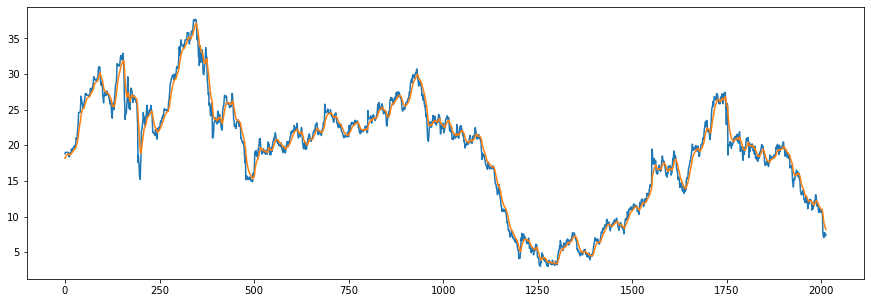

In [10]:
labels = []
sequential = []

train_sets = ['C6L.SI','O39.SI','600104.SS','0883.HK','1398.HK','ANF','AXL','JPM','CTB','TROX']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(41550, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(41550,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 37853, 0.0: 1852, 1.0: 1845})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:1845]
class_1 = class_1[0:1845]
class_2 = class_2[0:1845]

class_0_labels = class_0_labels[0:1845]
class_1_labels = class_1_labels[0:1845]
class_2_labels = class_2_labels[0:1845]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(5535, 15, 4)


Counter({0.0: 1845, 1.0: 1845, 2.0: 1845})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['C6L.SI','O39.SI','0883.HK','JPM','AXL']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 1 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/35 [..............................] - ETA: 0s - loss: 0.3821 - accuracy: 0.2578 - mse: 0.4866 - weighted_accuracy: 0.2578 - weighted_mse: 0.4866WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
35/35 [==============================] - 1s 31ms/step - loss: 0.2629 - accuracy: 0.3835 - mse: 0.5805 - weighted_accuracy: 0.3835 - weighted_mse: 0.5805 - val_loss: 0.2952 - val_accuracy: 0.3333 - val_mse: 0.3544 - val_weighted_accuracy: 0.3333 - val_weighted_mse: 0.3544
Epoch 2/20
35/35 [==============================] - 0s 8ms/step - loss: 0.1895 - accuracy: 0.4916 - mse: 0.9557 - weighted_accuracy: 0.4916 - weighted_mse: 0.9557 - val_loss: 0.2802 - val_accuracy: 0.3333 - val_mse: 0.3902 - val_weighted_accuracy: 0.33

7/7 [==============================] - 0s 3ms/step - loss: 0.1820 - accuracy: 0.3721 - mse: 1.5907 - weighted_accuracy: 0.3721 - weighted_mse: 1.5907
Test loss: 0.18202832341194153
Test accuracy: 0.3720930218696594


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 90
actual holds but predicted sell: 41
actual predicted holds: 67
Percentage buys correct: 7.070707070707071%
Percentage sells correct: 12.76595744680851%
Percentage holds correct: 97.10144927536231%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.474747474747474%
Percentage high sells correct: 57.4468085106383%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 2ms/step - loss: 0.1941 - accuracy: 0.3302 - mse: 1.5881 - weighted_accuracy: 0.3302 - weighted_mse: 1.5881
Test loss: 0.19414079189300537
Test accuracy: 0.33023256063461304


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 80
actual holds but predicted sell: 53
actual predicted holds: 60
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 8.620689655172415%
Percentage holds correct: 85.71428571428571%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.87356321839081%
Percentage high sells correct: 62.06896551724138%
Percentage mid holds correct: 78.26086956521739%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1819 - accuracy: 0.4272 - mse: 1.5903 - weighted_accuracy: 0.4272 - weighted_mse: 1.5903
Test loss: 0.18194879591464996
Test accuracy: 0.4272300601005554


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 81
actual holds but predicted sell: 34
actual predicted holds: 78
Percentage buys correct: 8.791208791208792%
Percentage sells correct: 12.820512820512821%
Percentage holds correct: 93.97590361445783%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.252747252747255%
Percentage high sells correct: 63.1578947368421%
Percentage mid holds correct: 87.95180722891567%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at

7/7 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.4658 - mse: 1.5102 - weighted_accuracy: 0.4658 - weighted_mse: 1.5102
Test loss: 0.176321879029274
Test accuracy: 0.465753436088562


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 65
actual holds but predicted sell: 43
actual predicted holds: 89
Percentage buys correct: 9.45945945945946%
Percentage sells correct: 12.244897959183673%
Percentage holds correct: 92.70833333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 43.83561643835616%
Percentage high sells correct: 59.183673469387756%
Percentage mid holds correct: 86.45833333333333%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price incr

7/7 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.4338 - mse: 1.5235 - weighted_accuracy: 0.4338 - weighted_mse: 1.5235
Test loss: 0.17563079297542572
Test accuracy: 0.4337899684906006


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 47
actual predicted holds: 80
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 12.962962962962964%
Percentage holds correct: 93.02325581395348%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.41025641025641%
Percentage high sells correct: 59.25925925925926%
Percentage mid holds correct: 87.20930232558139%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

35/35 [==============================] - 0s 7ms/step - loss: 0.1409 - accuracy: 0.6795 - mse: 1.6693 - weighted_accuracy: 0.6795 - weighted_mse: 1.6693 - val_loss: 0.1493 - val_accuracy: 0.6531 - val_mse: 1.7272 - val_weighted_accuracy: 0.6531 - val_weighted_mse: 1.7272
Epoch 8/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1401 - accuracy: 0.6850 - mse: 1.6889 - weighted_accuracy: 0.6850 - weighted_mse: 1.6889 - val_loss: 0.1478 - val_accuracy: 0.6603 - val_mse: 1.7296 - val_weighted_accuracy: 0.6603 - val_weighted_mse: 1.7296
Epoch 9/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1394 - accuracy: 0.6883 - mse: 1.6832 - weighted_accuracy: 0.6883 - weighted_mse: 1.6832 - val_loss: 0.1488 - val_accuracy: 0.6522 - val_mse: 1.7481 - val_weighted_accuracy: 0.6522 - val_weighted_mse: 1.7481
Epoch 10/20
35/35 [==============================] - 0s 8ms/step - loss: 0.1393 - accuracy: 0.6870 - mse: 1.7024 - weighted_accuracy: 0.6870 - weighted_mse: 1.7024 -

7/7 [==============================] - 0s 3ms/step - loss: 0.2288 - accuracy: 0.3628 - mse: 2.0756 - weighted_accuracy: 0.3628 - weighted_mse: 2.0756
Test loss: 0.2287781536579132
Test accuracy: 0.36279070377349854


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 78
actual holds but predicted sell: 56
actual predicted holds: 64
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.67741935483871%
Percentage holds correct: 98.46153846153847%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 52.27272727272727%
Percentage high sells correct: 59.01639344262295%
Percentage mid holds correct: 89.23076923076923%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price inc

7/7 [==============================] - 0s 3ms/step - loss: 0.2580 - accuracy: 0.2512 - mse: 2.1124 - weighted_accuracy: 0.2512 - weighted_mse: 2.1124
Test loss: 0.2579529583454132
Test accuracy: 0.2511627972126007


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 88
actual holds but predicted sell: 66
actual predicted holds: 39
Percentage buys correct: 8.16326530612245%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 88.63636363636364%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.08163265306123%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 84.0909090909091%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from pre

7/7 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.3380 - mse: 2.0687 - weighted_accuracy: 0.3380 - weighted_mse: 2.0687
Test loss: 0.22497519850730896
Test accuracy: 0.3380281627178192


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 78
actual holds but predicted sell: 57
actual predicted holds: 58
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.40909090909091%
Percentage high sells correct: 66.12903225806451%
Percentage mid holds correct: 90.3225806451613%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price 

7/7 [==============================] - 0s 4ms/step - loss: 0.2306 - accuracy: 0.3333 - mse: 1.9743 - weighted_accuracy: 0.3333 - weighted_mse: 1.9743
Test loss: 0.23063650727272034
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 65
actual predicted holds: 56
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 93.33333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.19277108433735%
Percentage high sells correct: 64.0%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from previously b

7/7 [==============================] - 0s 4ms/step - loss: 0.2359 - accuracy: 0.2922 - mse: 2.0406 - weighted_accuracy: 0.2922 - weighted_mse: 2.0406
Test loss: 0.23587101697921753
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 74
actual holds but predicted sell: 75
actual predicted holds: 48
Percentage buys correct: 10.714285714285714%
Percentage sells correct: 8.536585365853659%
Percentage holds correct: 90.56603773584905%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.42168674698795%
Percentage high sells correct: 59.75609756097561%
Percentage mid holds correct: 86.79245283018868%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

35/35 [==============================] - 0s 7ms/step - loss: 0.1301 - accuracy: 0.7164 - mse: 1.8295 - weighted_accuracy: 0.7164 - weighted_mse: 1.8295 - val_loss: 0.1527 - val_accuracy: 0.6531 - val_mse: 1.9562 - val_weighted_accuracy: 0.6531 - val_weighted_mse: 1.9562
Epoch 6/20
35/35 [==============================] - 0s 8ms/step - loss: 0.1290 - accuracy: 0.7222 - mse: 1.8481 - weighted_accuracy: 0.7222 - weighted_mse: 1.8481 - val_loss: 0.1556 - val_accuracy: 0.6432 - val_mse: 1.9480 - val_weighted_accuracy: 0.6432 - val_weighted_mse: 1.9480
Epoch 7/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1286 - accuracy: 0.7222 - mse: 1.8382 - weighted_accuracy: 0.7222 - weighted_mse: 1.8382 - val_loss: 0.1533 - val_accuracy: 0.6378 - val_mse: 1.9095 - val_weighted_accuracy: 0.6378 - val_weighted_mse: 1.9095
Epoch 8/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1280 - accuracy: 0.7283 - mse: 1.8680 - weighted_accuracy: 0.7283 - weighted_mse: 1.8680 - 

7/7 [==============================] - 0s 3ms/step - loss: 0.2620 - accuracy: 0.3674 - mse: 2.3194 - weighted_accuracy: 0.3674 - weighted_mse: 2.3194
Test loss: 0.26204270124435425
Test accuracy: 0.367441862821579


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 76
actual holds but predicted sell: 57
actual predicted holds: 65
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 98.48484848484848%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 51.16279069767442%
Percentage high sells correct: 59.67741935483871%
Percentage mid holds correct: 92.42424242424242%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price incr

7/7 [==============================] - 0s 2ms/step - loss: 0.2950 - accuracy: 0.2233 - mse: 2.3671 - weighted_accuracy: 0.2233 - weighted_mse: 2.3671
Test loss: 0.2949870526790619
Test accuracy: 0.22325581312179565


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 91
actual holds but predicted sell: 68
actual predicted holds: 34
Percentage buys correct: 7.070707070707071%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 87.17948717948718%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.525252525252526%
Percentage high sells correct: 59.21052631578947%
Percentage mid holds correct: 82.05128205128206%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.2507 - accuracy: 0.3239 - mse: 2.3331 - weighted_accuracy: 0.3239 - weighted_mse: 2.3331
Test loss: 0.2507320046424866
Test accuracy: 0.3239436745643616


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 88
actual holds but predicted sell: 50
actual predicted holds: 55
Percentage buys correct: 8.16326530612245%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 93.22033898305085%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 51.02040816326531%
Percentage high sells correct: 65.45454545454545%
Percentage mid holds correct: 86.44067796610169%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price 

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2594 - accuracy: 0.3288 - mse: 2.2060 - weighted_accuracy: 0.3288 - weighted_mse: 2.2060
Test loss: 0.2593540847301483
Test accuracy: 0.3287671208381653


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 1
actual holds but predicted buy: 75
actual holds but predicted sell: 69
actual predicted holds: 53
Percentage buys correct: 9.63855421686747%
Percentage sells correct: 13.75%
Percentage holds correct: 94.64285714285714%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 62.5%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $1.0008429154662593
Shares owned at the moment: 99
Cash capital at the moment: $0.644071885104637


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.2657 - accuracy: 0.2922 - mse: 2.2958 - weighted_accuracy: 0.2922 - weighted_mse: 2.2958
Test loss: 0.26573121547698975
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 76
actual holds but predicted sell: 74
actual predicted holds: 47
Percentage buys correct: 10.465116279069768%
Percentage sells correct: 9.75609756097561%
Percentage holds correct: 92.15686274509804%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.11764705882353%
Percentage high sells correct: 59.75609756097561%
Percentage mid holds correct: 90.19607843137256%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price

35/35 [==============================] - 0s 7ms/step - loss: 0.1200 - accuracy: 0.7473 - mse: 2.0071 - weighted_accuracy: 0.7473 - weighted_mse: 2.0071 - val_loss: 0.1535 - val_accuracy: 0.6450 - val_mse: 2.1285 - val_weighted_accuracy: 0.6450 - val_weighted_mse: 2.1285
Epoch 4/20
35/35 [==============================] - 0s 9ms/step - loss: 0.1178 - accuracy: 0.7595 - mse: 1.9890 - weighted_accuracy: 0.7595 - weighted_mse: 1.9890 - val_loss: 0.1541 - val_accuracy: 0.6396 - val_mse: 2.0219 - val_weighted_accuracy: 0.6396 - val_weighted_mse: 2.0219
Epoch 5/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1181 - accuracy: 0.7547 - mse: 2.0313 - weighted_accuracy: 0.7547 - weighted_mse: 2.0313 - val_loss: 0.1576 - val_accuracy: 0.6387 - val_mse: 2.2344 - val_weighted_accuracy: 0.6387 - val_weighted_mse: 2.2344
Epoch 6/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1169 - accuracy: 0.7633 - mse: 2.0476 - weighted_accuracy: 0.7633 - weighted_mse: 2.0476 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.3146 - accuracy: 0.3256 - mse: 2.7219 - weighted_accuracy: 0.3256 - weighted_mse: 2.7219
Test loss: 0.3146030902862549
Test accuracy: 0.3255814015865326


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 1
actual holds but predicted buy: 80
actual holds but predicted sell: 61
actual predicted holds: 57
Percentage buys correct: 7.865168539325842%
Percentage sells correct: 8.823529411764707%
Percentage holds correct: 98.27586206896552%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 50.561797752808985%
Percentage high sells correct: 58.208955223880594%
Percentage mid holds correct: 93.10344827586206%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.3488 - accuracy: 0.2419 - mse: 2.8194 - weighted_accuracy: 0.2419 - weighted_mse: 2.8194
Test loss: 0.34882357716560364
Test accuracy: 0.24186046421527863


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 89
actual holds but predicted sell: 67
actual predicted holds: 37
Percentage buys correct: 8.16326530612245%
Percentage sells correct: 9.333333333333334%
Percentage holds correct: 88.0952380952381%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.08163265306123%
Percentage high sells correct: 59.45945945945946%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price i

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.3427 - mse: 2.7500 - weighted_accuracy: 0.3427 - weighted_mse: 2.7500
Test loss: 0.2924654483795166
Test accuracy: 0.34272301197052


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 77
actual holds but predicted sell: 57
actual predicted holds: 59
Percentage buys correct: 9.195402298850574%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 93.65079365079364%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.275862068965516%
Percentage high sells correct: 61.29032258064516%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at th

7/7 [==============================] - 0s 3ms/step - loss: 0.3017 - accuracy: 0.3059 - mse: 2.5667 - weighted_accuracy: 0.3059 - weighted_mse: 2.5667
Test loss: 0.3017180860042572
Test accuracy: 0.3059360682964325


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 73
actual holds but predicted sell: 76
actual predicted holds: 48
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 12.64367816091954%
Percentage holds correct: 96.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.08641975308642%
Percentage high sells correct: 62.06896551724138%
Percentage mid holds correct: 88.0%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase from previously bo

7/7 [==============================] - 0s 2ms/step - loss: 0.3136 - accuracy: 0.2466 - mse: 2.6664 - weighted_accuracy: 0.2466 - weighted_mse: 2.6664
Test loss: 0.3136376142501831
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 76
actual holds but predicted sell: 84
actual predicted holds: 37
Percentage buys correct: 10.465116279069768%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 90.2439024390244%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.470588235294116%
Percentage high sells correct: 57.608695652173914%
Percentage mid holds correct: 87.8048780487805%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price

Epoch 3/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1075 - accuracy: 0.7866 - mse: 2.2456 - weighted_accuracy: 0.7866 - weighted_mse: 2.2456 - val_loss: 0.1591 - val_accuracy: 0.6441 - val_mse: 2.4234 - val_weighted_accuracy: 0.6441 - val_weighted_mse: 2.4234
Epoch 4/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1046 - accuracy: 0.7977 - mse: 2.2293 - weighted_accuracy: 0.7977 - weighted_mse: 2.2293 - val_loss: 0.1630 - val_accuracy: 0.6360 - val_mse: 2.3633 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 2.3633
Epoch 5/20
35/35 [==============================] - 0s 7ms/step - loss: 0.1056 - accuracy: 0.7870 - mse: 2.2784 - weighted_accuracy: 0.7870 - weighted_mse: 2.2784 - val_loss: 0.1606 - val_accuracy: 0.6405 - val_mse: 2.5386 - val_weighted_accuracy: 0.6405 - val_weighted_mse: 2.5386
Epoch 6/20
35/35 [==============================] - 0s 8ms/step - loss: 0.1044 - accuracy: 0.7938 - mse: 2.3030 - weighted_accuracy: 0.7938 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.3576 - accuracy: 0.3442 - mse: 3.0878 - weighted_accuracy: 0.3442 - weighted_mse: 3.0878
Test loss: 0.3576262295246124
Test accuracy: 0.34418603777885437


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 66
actual predicted holds: 61
Percentage buys correct: 8.860759493670885%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 96.82539682539682%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 51.89873417721519%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 92.06349206349206%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price i

1         -55.902029  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.3716 - accuracy: 0.2744 - mse: 3.1200 - weighted_accuracy: 0.2744 - weighted_mse: 3.1200
Test loss: 0.3716287314891815
Test accuracy: 0.27441859245300293


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 77
actual holds but predicted sell: 71
actual predicted holds: 45
Percentage buys correct: 8.235294117647058%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 86.53846153846153%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.94117647058823%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 80.76923076923077%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at

2         -54.689601  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.3568 - mse: 3.0755 - weighted_accuracy: 0.3568 - weighted_mse: 3.0755
Test loss: 0.3248838782310486
Test accuracy: 0.35680750012397766


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 69
actual holds but predicted sell: 62
actual predicted holds: 62
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 95.38461538461539%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.36708860759494%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 85.9375%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the momen

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.3302 - accuracy: 0.3196 - mse: 2.8575 - weighted_accuracy: 0.3196 - weighted_mse: 2.8575
Test loss: 0.33015692234039307
Test accuracy: 0.31963470578193665


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 11
actual sells but predicted hold: 1
actual holds but predicted buy: 68
actual holds but predicted sell: 78
actual predicted holds: 51
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 12.359550561797754%
Percentage holds correct: 94.44444444444444%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.94736842105263%
Percentage high sells correct: 59.09090909090909%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital

7/7 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.2374 - mse: 2.9801 - weighted_accuracy: 0.2374 - weighted_mse: 2.9801
Test loss: 0.3524499535560608
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 66
actual holds but predicted sell: 96
actual predicted holds: 35
Percentage buys correct: 12.0%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 87.5%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.75675675675676%
Percentage high sells correct: 53.84615384615385%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price increase from previously bought: -72.6

35/35 [==============================] - 0s 7ms/step - loss: 0.0917 - accuracy: 0.8329 - mse: 2.5847 - weighted_accuracy: 0.8329 - weighted_mse: 2.5847 - val_loss: 0.1756 - val_accuracy: 0.6522 - val_mse: 2.8711 - val_weighted_accuracy: 0.6522 - val_weighted_mse: 2.8711
Epoch 8/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0906 - accuracy: 0.8302 - mse: 2.6415 - weighted_accuracy: 0.8302 - weighted_mse: 2.6415 - val_loss: 0.1731 - val_accuracy: 0.6369 - val_mse: 2.8036 - val_weighted_accuracy: 0.6369 - val_weighted_mse: 2.8036
Epoch 9/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0896 - accuracy: 0.8336 - mse: 2.6371 - weighted_accuracy: 0.8336 - weighted_mse: 2.6371 - val_loss: 0.1748 - val_accuracy: 0.6215 - val_mse: 2.7179 - val_weighted_accuracy: 0.6215 - val_weighted_mse: 2.7179
Epoch 10/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0908 - accuracy: 0.8268 - mse: 2.6617 - weighted_accuracy: 0.8268 - weighted_mse: 2.6617 -

7/7 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.3442 - mse: 3.5828 - weighted_accuracy: 0.3442 - weighted_mse: 3.5828
Test loss: 0.4248652160167694
Test accuracy: 0.34418603777885437


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 69
actual holds but predicted sell: 68
actual predicted holds: 61
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.0%
Percentage holds correct: 96.82539682539682%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.35064935064935%
Percentage high sells correct: 54.054054054054056%
Percentage mid holds correct: 90.47619047619048%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from p

7/7 [==============================] - 0s 3ms/step - loss: 0.4315 - accuracy: 0.2558 - mse: 3.5531 - weighted_accuracy: 0.2558 - weighted_mse: 3.5531
Test loss: 0.4314950704574585
Test accuracy: 0.25581395626068115


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 77
actual holds but predicted sell: 76
actual predicted holds: 40
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 86.95652173913044%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.651162790697676%
Percentage high sells correct: 56.09756097560975%
Percentage mid holds correct: 80.43478260869566%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 2ms/step - loss: 0.3996 - accuracy: 0.3474 - mse: 3.5275 - weighted_accuracy: 0.3474 - weighted_mse: 3.5275
Test loss: 0.39963945746421814
Test accuracy: 0.34741783142089844


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 70
actual holds but predicted sell: 64
actual predicted holds: 59
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 9.722222222222221%
Percentage holds correct: 95.16129032258064%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.36708860759494%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 85.24590163934427%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pr

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.4010 - accuracy: 0.3105 - mse: 3.2956 - weighted_accuracy: 0.3105 - weighted_mse: 3.2956
Test loss: 0.40101248025894165
Test accuracy: 0.310502290725708


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 69
actual holds but predicted sell: 80
actual predicted holds: 48
Percentage buys correct: 11.39240506329114%
Percentage sells correct: 12.087912087912088%
Percentage holds correct: 97.95918367346938%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 54.43037974683544%
Percentage high sells correct: 57.77777777777778%
Percentage mid holds correct: 89.79591836734694%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at

7/7 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.2557 - mse: 3.4655 - weighted_accuracy: 0.2557 - weighted_mse: 3.4655
Test loss: 0.435649573802948
Test accuracy: 0.2557077705860138


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 60
actual holds but predicted sell: 98
actual predicted holds: 39
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 7.547169811320755%
Percentage holds correct: 88.63636363636364%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.35294117647059%
Percentage high sells correct: 54.716981132075475%
Percentage mid holds correct: 86.36363636363636%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price 

35/35 [==============================] - 0s 7ms/step - loss: 0.0805 - accuracy: 0.8591 - mse: 2.9602 - weighted_accuracy: 0.8591 - weighted_mse: 2.9602 - val_loss: 0.1881 - val_accuracy: 0.6378 - val_mse: 3.2601 - val_weighted_accuracy: 0.6378 - val_weighted_mse: 3.2601
Epoch 8/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0795 - accuracy: 0.8613 - mse: 3.0247 - weighted_accuracy: 0.8613 - weighted_mse: 3.0247 - val_loss: 0.1835 - val_accuracy: 0.6341 - val_mse: 3.2726 - val_weighted_accuracy: 0.6341 - val_weighted_mse: 3.2726
Epoch 9/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0785 - accuracy: 0.8636 - mse: 3.0494 - weighted_accuracy: 0.8636 - weighted_mse: 3.0494 - val_loss: 0.1907 - val_accuracy: 0.6098 - val_mse: 3.1893 - val_weighted_accuracy: 0.6098 - val_weighted_mse: 3.1893
Epoch 10/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0796 - accuracy: 0.8561 - mse: 3.0622 - weighted_accuracy: 0.8561 - weighted_mse: 3.0622 -

7/7 [==============================] - 0s 3ms/step - loss: 0.5014 - accuracy: 0.3535 - mse: 4.2231 - weighted_accuracy: 0.3535 - weighted_mse: 4.2231
Test loss: 0.5014247298240662
Test accuracy: 0.35348838567733765


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 68
actual holds but predicted sell: 67
actual predicted holds: 63
Percentage buys correct: 9.210526315789474%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 96.92307692307692%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 52.054794520547944%
Percentage mid holds correct: 90.76923076923077%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from 

7/7 [==============================] - 0s 3ms/step - loss: 0.5022 - accuracy: 0.2326 - mse: 4.1473 - weighted_accuracy: 0.2326 - weighted_mse: 4.1473
Test loss: 0.5021682977676392
Test accuracy: 0.23255814611911774


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 79
actual predicted holds: 35
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 85.36585365853658%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 55.68181818181818%
Percentage high sells correct: 55.294117647058826%
Percentage mid holds correct: 80.48780487804878%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.4805 - accuracy: 0.3005 - mse: 4.1283 - weighted_accuracy: 0.3005 - weighted_mse: 4.1283
Test loss: 0.4805331528186798
Test accuracy: 0.3004694879055023


number of predictions: 213
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 70
actual predicted holds: 49
Percentage buys correct: 9.63855421686747%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 94.23076923076923%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.397590361445786%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 82.6923076923077%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price 

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.3014 - mse: 3.8857 - weighted_accuracy: 0.3014 - weighted_mse: 3.8857
Test loss: 0.4725993275642395
Test accuracy: 0.30136987566947937


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 66
actual holds but predicted sell: 84
actual predicted holds: 47
Percentage buys correct: 10.666666666666666%
Percentage sells correct: 11.578947368421053%
Percentage holds correct: 95.91836734693878%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 54.666666666666664%
Percentage high sells correct: 57.4468085106383%
Percentage mid holds correct: 89.79591836734694%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital 

7/7 [==============================] - 0s 2ms/step - loss: 0.5359 - accuracy: 0.2511 - mse: 4.1199 - weighted_accuracy: 0.2511 - weighted_mse: 4.1199
Test loss: 0.5359461307525635
Test accuracy: 0.2511415481567383


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 59
actual holds but predicted sell: 99
actual predicted holds: 39
Percentage buys correct: 11.940298507462687%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 86.66666666666667%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.06060606060606%
Percentage high sells correct: 54.205607476635514%
Percentage mid holds correct: 84.44444444444444%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

Epoch 5/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0719 - accuracy: 0.8794 - mse: 3.3727 - weighted_accuracy: 0.8794 - weighted_mse: 3.3727 - val_loss: 0.2031 - val_accuracy: 0.6387 - val_mse: 3.6843 - val_weighted_accuracy: 0.6387 - val_weighted_mse: 3.6843
Epoch 6/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0715 - accuracy: 0.8848 - mse: 3.4025 - weighted_accuracy: 0.8848 - weighted_mse: 3.4025 - val_loss: 0.2071 - val_accuracy: 0.6504 - val_mse: 3.8571 - val_weighted_accuracy: 0.6504 - val_weighted_mse: 3.8571
Epoch 7/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0700 - accuracy: 0.8832 - mse: 3.4116 - weighted_accuracy: 0.8832 - weighted_mse: 3.4116 - val_loss: 0.2027 - val_accuracy: 0.6459 - val_mse: 3.7141 - val_weighted_accuracy: 0.6459 - val_weighted_mse: 3.7141
Epoch 8/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0694 - accuracy: 0.8837 - mse: 3.4681 - weighted_accuracy: 0.8837 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.5844 - accuracy: 0.3442 - mse: 4.8242 - weighted_accuracy: 0.3442 - weighted_mse: 4.8242
Test loss: 0.5844465494155884
Test accuracy: 0.34418603777885437


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 66
actual predicted holds: 61
Percentage buys correct: 8.860759493670885%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 96.82539682539682%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.10126582278481%
Percentage high sells correct: 52.77777777777778%
Percentage mid holds correct: 90.47619047619048%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price in

7/7 [==============================] - 0s 3ms/step - loss: 0.5548 - accuracy: 0.2558 - mse: 4.6242 - weighted_accuracy: 0.2558 - weighted_mse: 4.6242
Test loss: 0.5547820925712585
Test accuracy: 0.25581395626068115


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 76
actual holds but predicted sell: 77
actual predicted holds: 40
Percentage buys correct: 9.411764705882353%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 86.95652173913044%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 55.294117647058826%
Percentage high sells correct: 54.21686746987952%
Percentage mid holds correct: 80.43478260869566%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

7/7 [==============================] - 0s 2ms/step - loss: 0.5457 - accuracy: 0.3192 - mse: 4.6849 - weighted_accuracy: 0.3192 - weighted_mse: 4.6849
Test loss: 0.5456560254096985
Test accuracy: 0.31924882531166077


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 65
actual predicted holds: 54
Percentage buys correct: 8.536585365853659%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 93.10344827586206%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.78048780487805%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 82.75862068965517%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price

3        1576.179166  
Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.5296 - accuracy: 0.2922 - mse: 4.3616 - weighted_accuracy: 0.2922 - weighted_mse: 4.3616
Test loss: 0.529613196849823
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 70
actual holds but predicted sell: 82
actual predicted holds: 45
Percentage buys correct: 10.126582278481013%
Percentage sells correct: 11.827956989247312%
Percentage holds correct: 95.74468085106383%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.89873417721519%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 89.36170212765957%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital a

7/7 [==============================] - 0s 2ms/step - loss: 0.6147 - accuracy: 0.2374 - mse: 4.7082 - weighted_accuracy: 0.2374 - weighted_mse: 4.7082
Test loss: 0.6146507859230042
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 62
actual holds but predicted sell: 99
actual predicted holds: 36
Percentage buys correct: 11.267605633802816%
Percentage sells correct: 7.4766355140186915%
Percentage holds correct: 87.8048780487805%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 55.14018691588785%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

Epoch 7/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0611 - accuracy: 0.9045 - mse: 3.9206 - weighted_accuracy: 0.9045 - weighted_mse: 3.9206 - val_loss: 0.2240 - val_accuracy: 0.6341 - val_mse: 4.2325 - val_weighted_accuracy: 0.6341 - val_weighted_mse: 4.2325
Epoch 8/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0608 - accuracy: 0.9009 - mse: 3.9860 - weighted_accuracy: 0.9009 - weighted_mse: 3.9860 - val_loss: 0.2244 - val_accuracy: 0.6423 - val_mse: 4.3208 - val_weighted_accuracy: 0.6423 - val_weighted_mse: 4.3208
Epoch 9/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9029 - mse: 4.0347 - weighted_accuracy: 0.9029 - weighted_mse: 4.0347 - val_loss: 0.2328 - val_accuracy: 0.6260 - val_mse: 4.2659 - val_weighted_accuracy: 0.6260 - val_weighted_mse: 4.2659
Epoch 10/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0609 - accuracy: 0.9029 - mse: 4.0298 - weighted_accuracy: 0.9029 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.6843 - accuracy: 0.3535 - mse: 5.5289 - weighted_accuracy: 0.3535 - weighted_mse: 5.5289
Test loss: 0.6842800974845886
Test accuracy: 0.35348838567733765


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 69
actual holds but predicted sell: 67
actual predicted holds: 62
Percentage buys correct: 9.210526315789474%
Percentage sells correct: 9.333333333333334%
Percentage holds correct: 96.875%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 51.351351351351354%
Percentage mid holds correct: 89.0625%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previous

7/7 [==============================] - 0s 2ms/step - loss: 0.6347 - accuracy: 0.2465 - mse: 5.1368 - weighted_accuracy: 0.2465 - weighted_mse: 5.1368
Test loss: 0.6346933841705322
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 79
actual predicted holds: 40
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 7.954545454545454%
Percentage holds correct: 86.95652173913044%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 54.02298850574713%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.3052 - mse: 5.3166 - weighted_accuracy: 0.3052 - weighted_mse: 5.3166
Test loss: 0.6397126317024231
Test accuracy: 0.30516430735588074


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 73
actual holds but predicted sell: 70
actual predicted holds: 50
Percentage buys correct: 8.641975308641975%
Percentage sells correct: 10.126582278481013%
Percentage holds correct: 94.33962264150944%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 49.382716049382715%
Percentage high sells correct: 60.256410256410255%
Percentage mid holds correct: 84.90566037735849%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pr

7/7 [==============================] - 0s 2ms/step - loss: 0.6217 - accuracy: 0.2968 - mse: 4.9257 - weighted_accuracy: 0.2968 - weighted_mse: 4.9257
Test loss: 0.6216937899589539
Test accuracy: 0.29680365324020386


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 11
actual sells but predicted hold: 0
actual holds but predicted buy: 65
actual holds but predicted sell: 86
actual predicted holds: 46
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 11.34020618556701%
Percentage holds correct: 95.83333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 89.58333333333333%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase fro

7/7 [==============================] - 0s 3ms/step - loss: 0.7356 - accuracy: 0.2374 - mse: 5.3960 - weighted_accuracy: 0.2374 - weighted_mse: 5.3960
Test loss: 0.7355754375457764
Test accuracy: 0.23744292557239532


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 61
actual holds but predicted sell: 100
actual predicted holds: 36
Percentage buys correct: 11.428571428571429%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 87.8048780487805%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 57.971014492753625%
Percentage high sells correct: 56.48148148148148%
Percentage mid holds correct: 85.36585365853658%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Pric

Epoch 3/20
35/35 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9162 - mse: 4.3294 - weighted_accuracy: 0.9162 - weighted_mse: 4.3294 - val_loss: 0.2364 - val_accuracy: 0.6531 - val_mse: 4.6346 - val_weighted_accuracy: 0.6531 - val_weighted_mse: 4.6346
Epoch 4/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.9128 - mse: 4.3681 - weighted_accuracy: 0.9128 - weighted_mse: 4.3681 - val_loss: 0.2571 - val_accuracy: 0.6369 - val_mse: 4.9010 - val_weighted_accuracy: 0.6369 - val_weighted_mse: 4.9010
Epoch 5/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0550 - accuracy: 0.9198 - mse: 4.4537 - weighted_accuracy: 0.9198 - weighted_mse: 4.4537 - val_loss: 0.2459 - val_accuracy: 0.6441 - val_mse: 4.6871 - val_weighted_accuracy: 0.6441 - val_weighted_mse: 4.6871
Epoch 6/20
35/35 [==============================] - 0s 7ms/step - loss: 0.0550 - accuracy: 0.9219 - mse: 4.4815 - weighted_accuracy: 0.9219 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.7329 - accuracy: 0.3721 - mse: 6.2003 - weighted_accuracy: 0.3721 - weighted_mse: 6.2003
Test loss: 0.7328766584396362
Test accuracy: 0.3720930218696594


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 67
actual holds but predicted sell: 65
actual predicted holds: 66
Percentage buys correct: 9.45945945945946%
Percentage sells correct: 9.58904109589041%
Percentage holds correct: 97.05882352941177%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.2972972972973%
Percentage high sells correct: 51.388888888888886%
Percentage mid holds correct: 89.70588235294117%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price incre

7/7 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.2791 - mse: 5.5826 - weighted_accuracy: 0.2791 - weighted_mse: 5.5826
Test loss: 0.6594509482383728
Test accuracy: 0.27906978130340576


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 74
actual holds but predicted sell: 72
actual predicted holds: 47
Percentage buys correct: 7.407407407407407%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 88.67924528301887%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 54.32098765432099%
Percentage high sells correct: 52.5%
Percentage mid holds correct: 83.01886792452831%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price increase from

7/7 [==============================] - 0s 2ms/step - loss: 0.6938 - accuracy: 0.3052 - mse: 5.9643 - weighted_accuracy: 0.3052 - weighted_mse: 5.9643
Test loss: 0.6938450932502747
Test accuracy: 0.30516430735588074


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 73
actual holds but predicted sell: 69
actual predicted holds: 51
Percentage buys correct: 8.641975308641975%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 92.72727272727273%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.617283950617285%
Percentage high sells correct: 56.578947368421055%
Percentage mid holds correct: 85.45454545454545%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.3105 - mse: 5.3246 - weighted_accuracy: 0.3105 - weighted_mse: 5.3246
Test loss: 0.6427927017211914
Test accuracy: 0.310502290725708


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 67
actual holds but predicted sell: 80
actual predicted holds: 50
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 94.33962264150944%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.94736842105263%
Percentage high sells correct: 55.056179775280896%
Percentage mid holds correct: 88.67924528301887%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.7492 - accuracy: 0.2740 - mse: 5.7717 - weighted_accuracy: 0.2740 - weighted_mse: 5.7717
Test loss: 0.7492434978485107
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 59
actual holds but predicted sell: 95
actual predicted holds: 43
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 7.766990291262136%
Percentage holds correct: 91.48936170212765%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 58.8235294117647%
Percentage high sells correct: 55.33980582524272%
Percentage mid holds correct: 89.36170212765957%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price 

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0     -86.088905
1     -84.528731
2     456.363096
3    8069.978490
4     234.594528
Name: Profit gained, dtype: float64

In [21]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


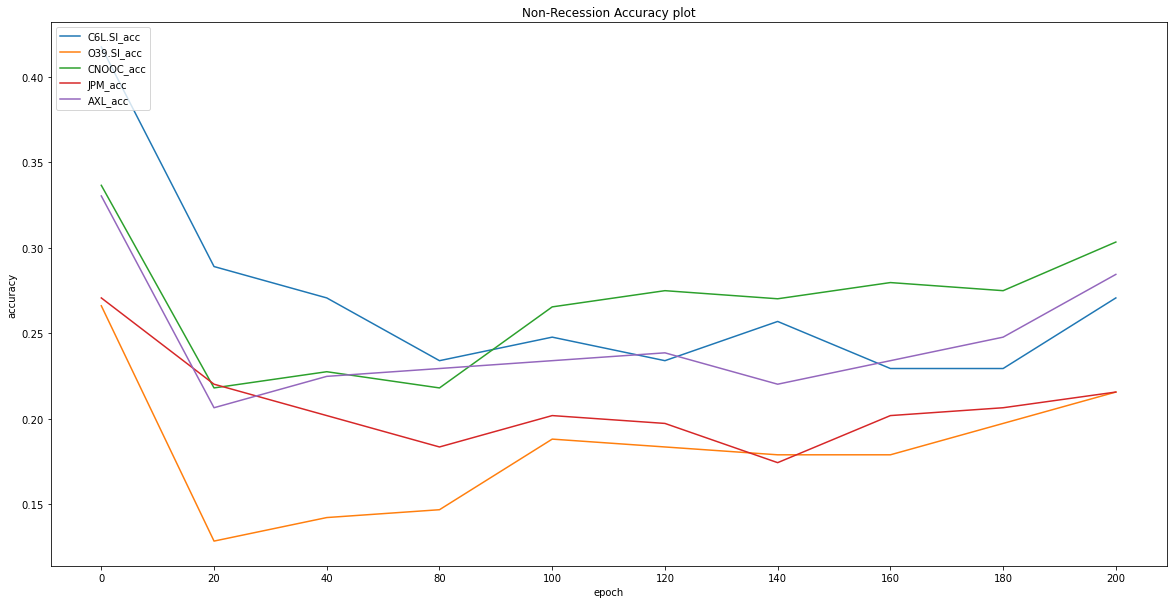

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

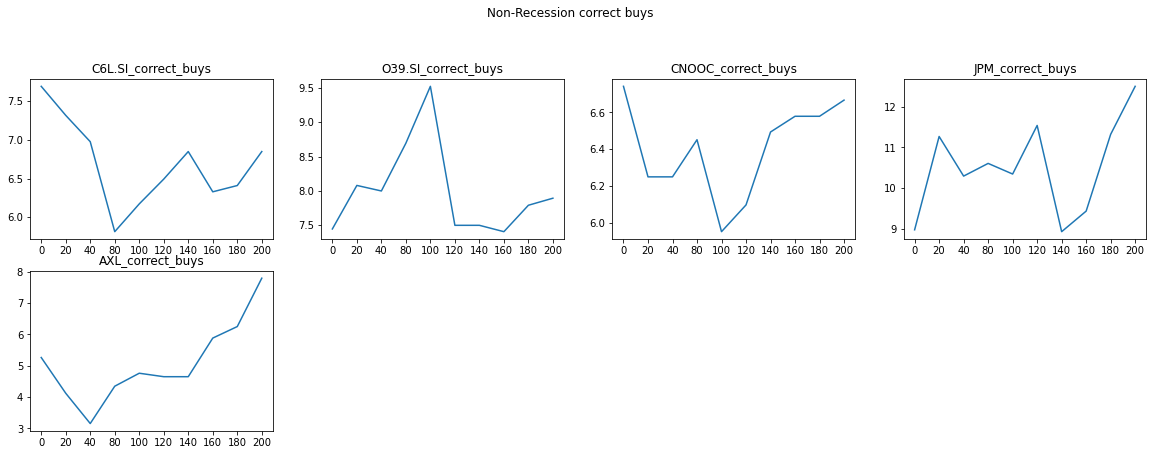

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

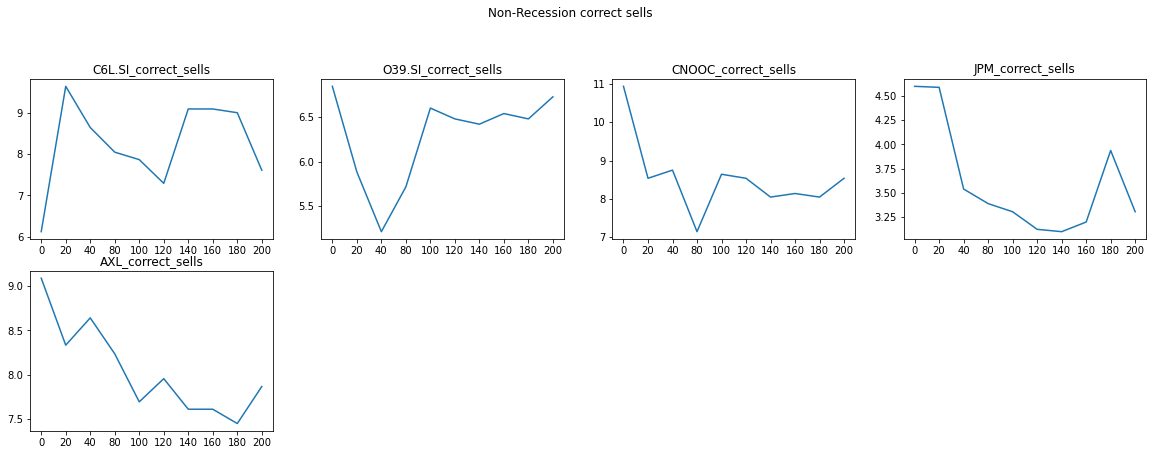

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

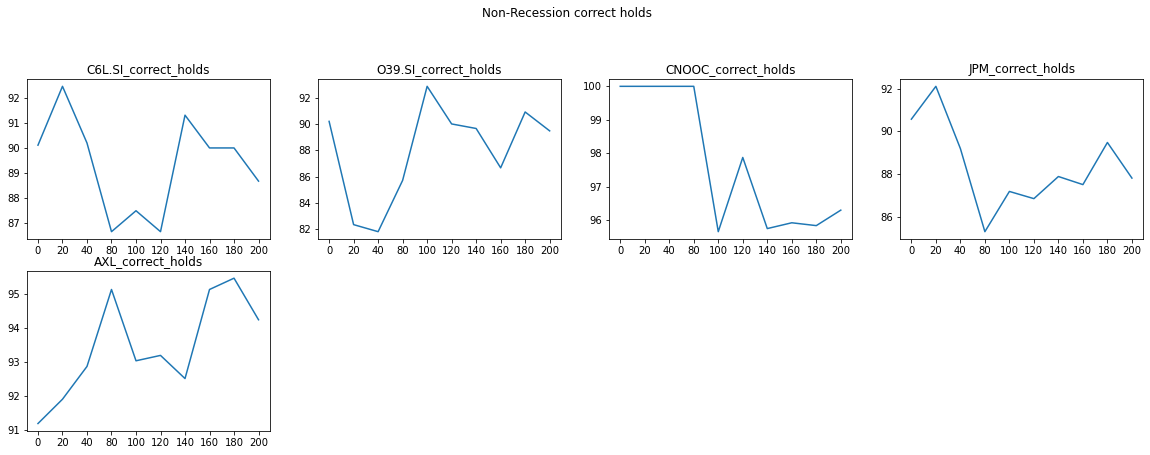

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

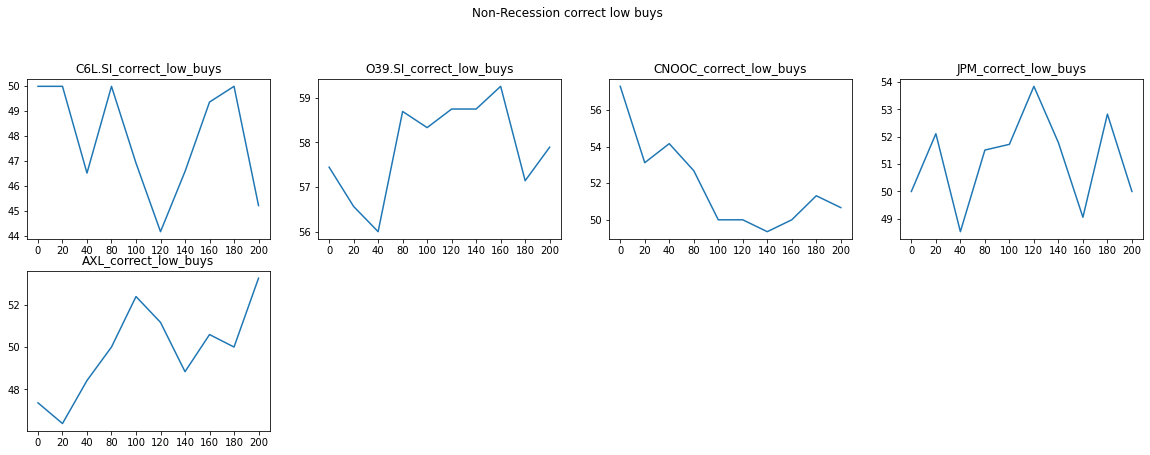

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

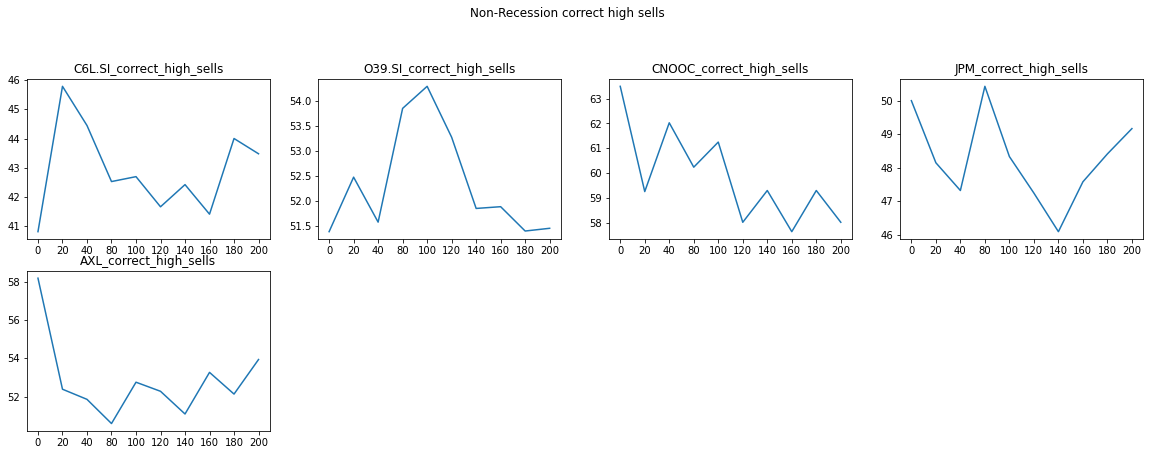

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

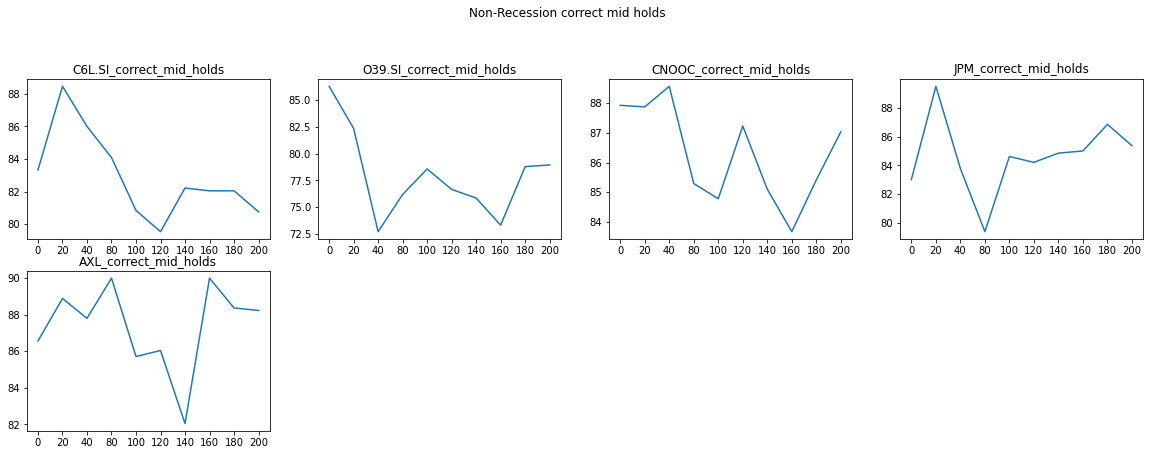

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

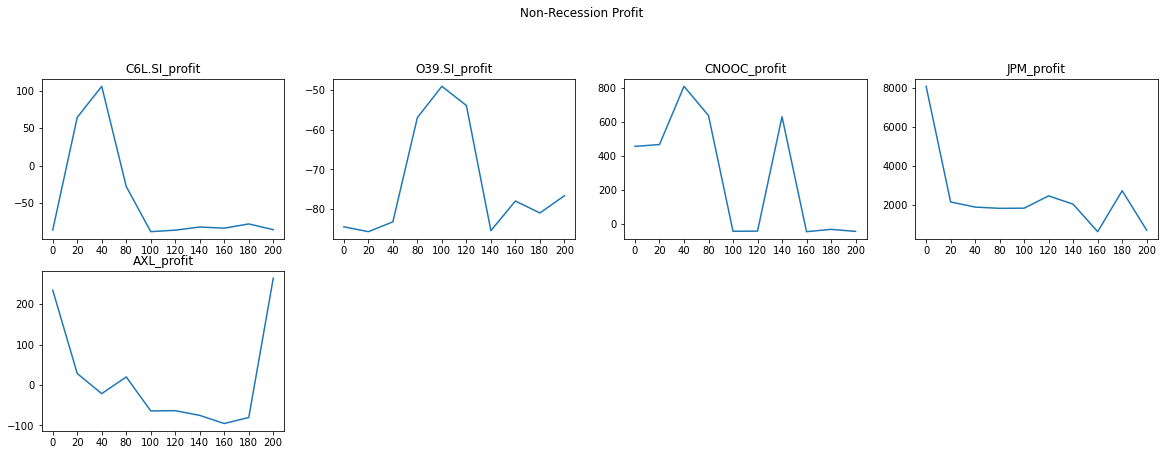

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")

In [30]:
C6LSI_acc = []
O39SI_acc = []
CNOOC_acc = []
JPM_acc = []
AXL_acc = []

C6LSI_correct_buys = []
O39SI_correct_buys = []
CNOOC_correct_buys = []
JPM_correct_buys = []
AXL_correct_buys = []

C6LSI_correct_sells = []
O39SI_correct_sells = []
CNOOC_correct_sells = []
JPM_correct_sells = []
AXL_correct_sells = []

C6LSI_correct_holds = []
O39SI_correct_holds = []
CNOOC_correct_holds = []
JPM_correct_holds = []
AXL_correct_holds = []

C6LSI_correct_low_buys = []
O39SI_correct_low_buys = []
CNOOC_correct_low_buys = []
JPM_correct_low_buys = []
AXL_correct_low_buys = []

C6LSI_correct_high_sells = []
O39SI_correct_high_sells = []
CNOOC_correct_high_sells = []
JPM_correct_high_sells = []
AXL_correct_high_sells = []

C6LSI_correct_mid_holds = []
O39SI_correct_mid_holds = []
CNOOC_correct_mid_holds = []
JPM_correct_mid_holds = []
AXL_correct_mid_holds = []

C6LSI_profit = []
O39SI_profit = []
CNOOC_profit = []
JPM_profit = []
AXL_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    C6LSI_acc.append(acc[0])
    O39SI_acc.append(acc[1])
    CNOOC_acc.append(acc[2])
    JPM_acc.append(acc[3]) 
    AXL_acc.append(acc[4]) 

    C6LSI_correct_buys.append(correct_buys[0])
    O39SI_correct_buys.append(correct_buys[1]) 
    CNOOC_correct_buys.append(correct_buys[2]) 
    JPM_correct_buys.append(correct_buys[3]) 
    AXL_correct_buys.append(correct_buys[4])
    

    C6LSI_correct_sells.append(correct_sells[0]) 
    O39SI_correct_sells.append(correct_sells[1]) 
    CNOOC_correct_sells.append(correct_sells[2]) 
    JPM_correct_sells.append(correct_sells[3]) 
    AXL_correct_sells.append(correct_sells[4]) 
    

    C6LSI_correct_holds.append(correct_holds[0]) 
    O39SI_correct_holds.append(correct_holds[1])  
    CNOOC_correct_holds.append(correct_holds[2])  
    JPM_correct_holds.append(correct_holds[3])  
    AXL_correct_holds.append(correct_holds[4])  
     

    C6LSI_correct_low_buys.append(correct_low_buys[0])  
    O39SI_correct_low_buys.append(correct_low_buys[1])  
    CNOOC_correct_low_buys.append(correct_low_buys[2])  
    JPM_correct_low_buys.append(correct_low_buys[3])   
    AXL_correct_low_buys.append(correct_low_buys[4])   
    

    C6LSI_correct_high_sells.append(correct_high_sells[0]) 
    O39SI_correct_high_sells.append(correct_high_sells[1]) 
    CNOOC_correct_high_sells.append(correct_high_sells[2]) 
    JPM_correct_high_sells.append(correct_high_sells[3]) 
    AXL_correct_high_sells.append(correct_high_sells[4]) 
    

    C6LSI_correct_mid_holds.append(correct_mid_holds[0])  
    O39SI_correct_mid_holds.append(correct_mid_holds[1])  
    CNOOC_correct_mid_holds.append(correct_mid_holds[2])   
    JPM_correct_mid_holds.append(correct_mid_holds[3])   
    AXL_correct_mid_holds.append(correct_mid_holds[4])   
    

    C6LSI_profit.append(profit[0]) 
    O39SI_profit.append(profit[1]) 
    CNOOC_profit.append(profit[2]) 
    JPM_profit.append(profit[3])  
    AXL_profit.append(profit[4])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


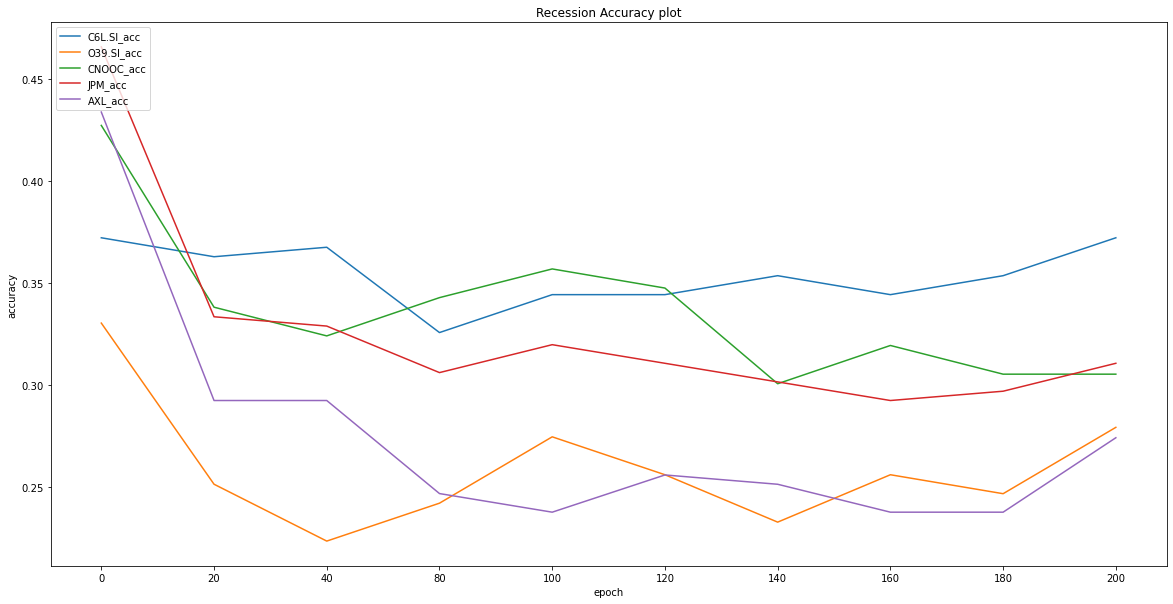

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(C6LSI_acc)
plt.plot(O39SI_acc)
plt.plot(CNOOC_acc)
plt.plot(JPM_acc)
plt.plot(AXL_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['C6L.SI_acc','O39.SI_acc','CNOOC_acc','JPM_acc','AXL_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'AXL_correct_buys')

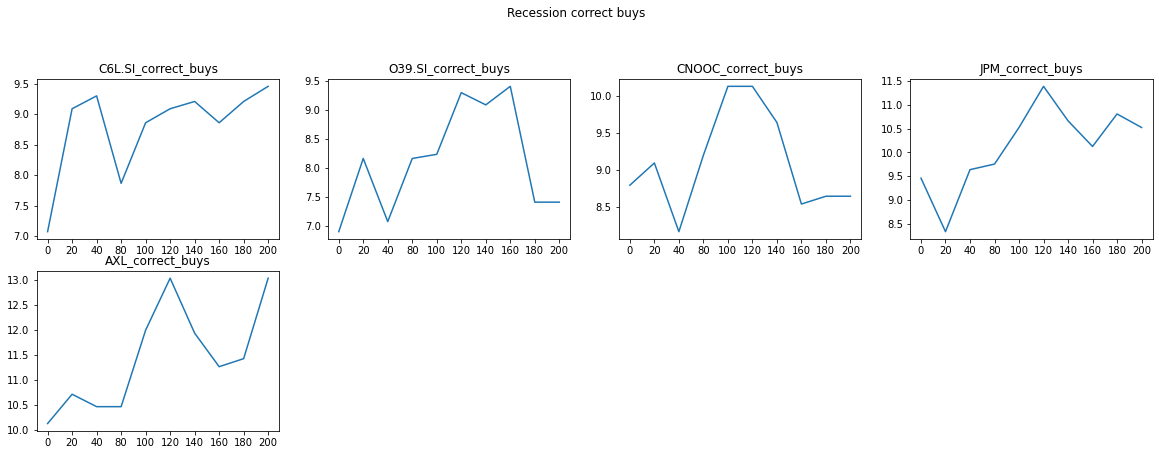

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_buys")

Text(0.5, 1.0, 'AXL_correct_sells')

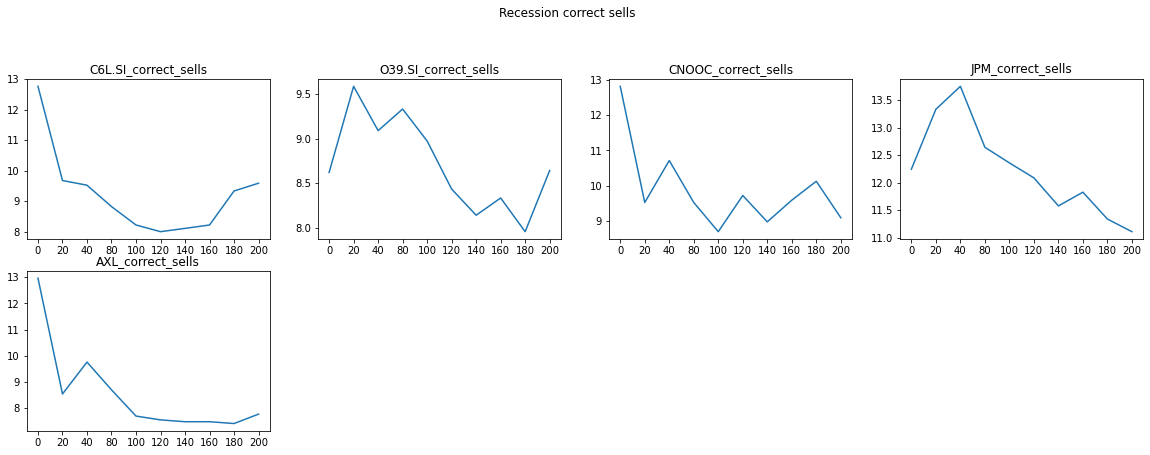

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_sells")

Text(0.5, 1.0, 'AXL_correct_holds')

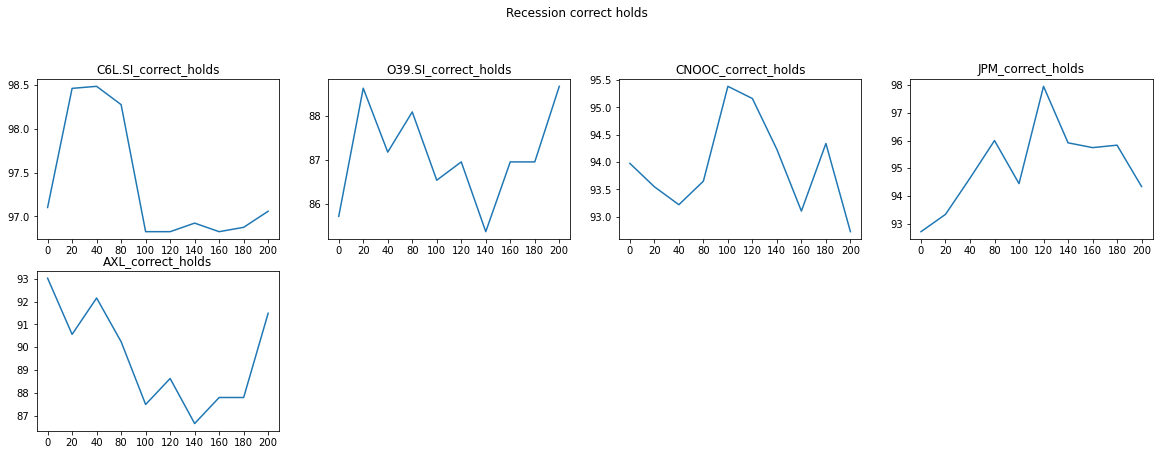

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_holds")

Text(0.5, 1.0, 'AXL_correct_low_buys')

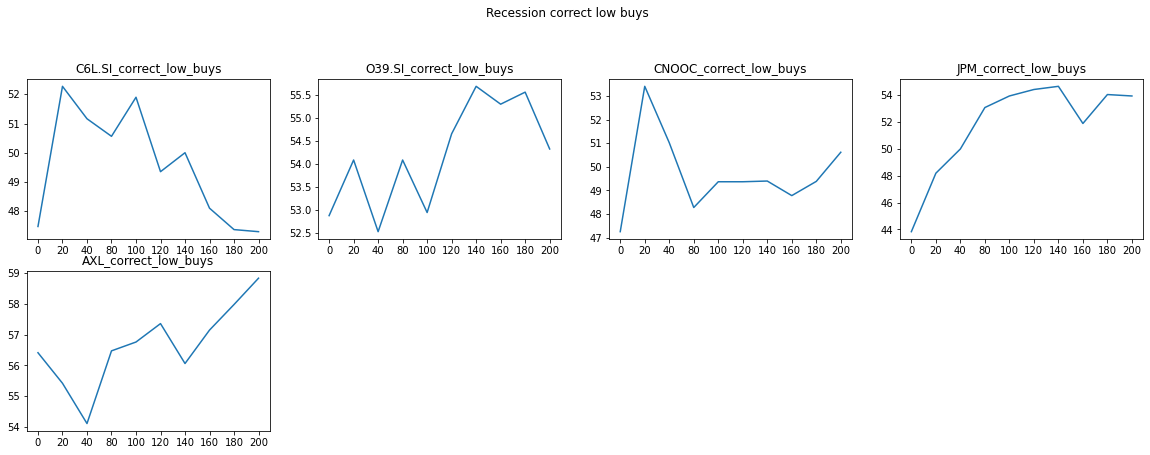

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_low_buys")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_low_buys")

Text(0.5, 1.0, 'AXL_correct_high_sells')

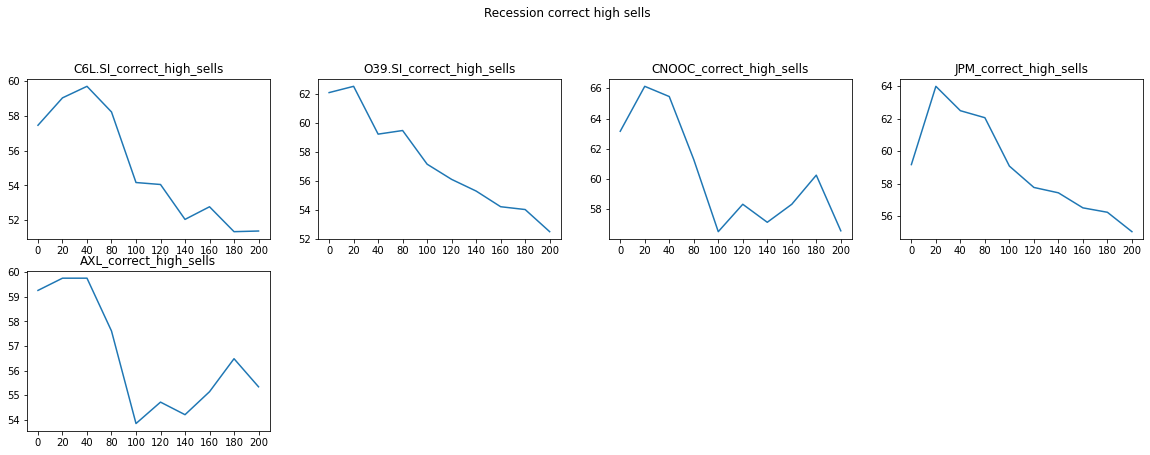

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_high_sells")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_high_sells")

Text(0.5, 1.0, 'AXL_correct_mid_holds')

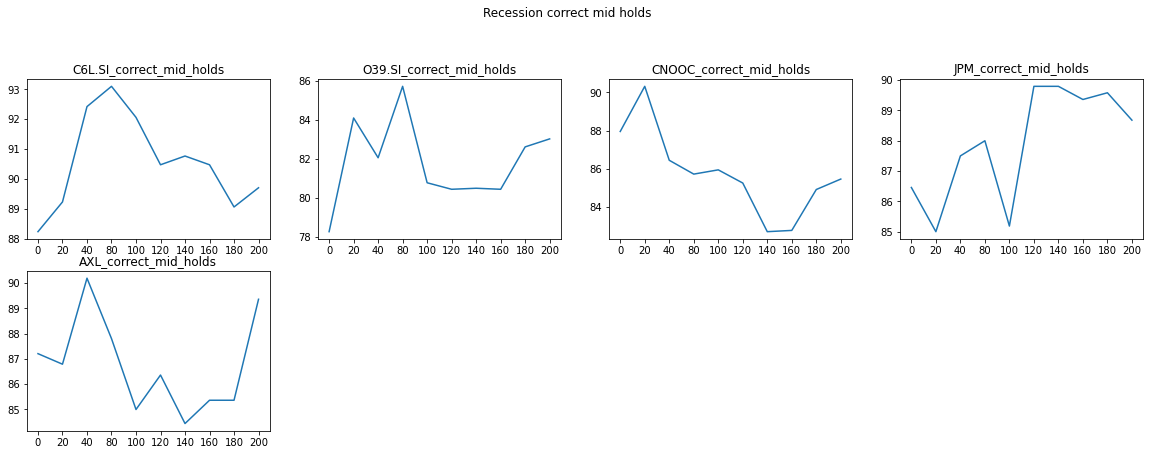

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(O39SI_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(JPM_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_correct_mid_holds")

plt.subplot(3, 4, 5)
plt.plot(AXL_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_correct_mid_holds")

Text(0.5, 1.0, 'AXL_profit')

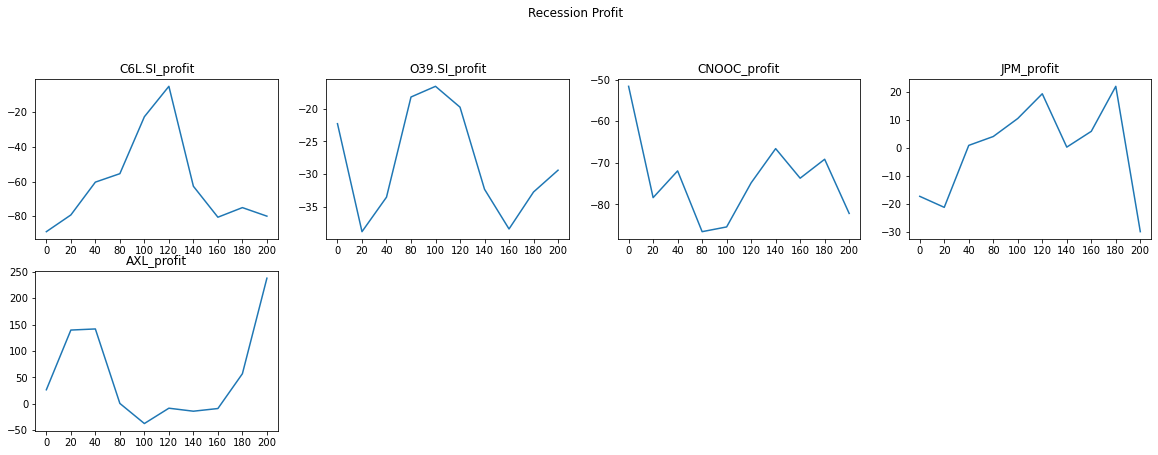

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(C6LSI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("C6L.SI_profit")

plt.subplot(3, 4, 2)
plt.plot(O39SI_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("O39.SI_profit")

plt.subplot(3, 4, 3)
plt.plot(CNOOC_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("CNOOC_profit")

plt.subplot(3, 4, 4)
plt.plot(JPM_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("JPM_profit")

plt.subplot(3, 4, 5)
plt.plot(AXL_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("AXL_profit")